# Gender Prediction based on Bag of Words
- all prompts of a user are concatenated and then vectorized
use expanded prompts wihtout capitalization, new lines and punctuation

In [12]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('../../../data/giicg.db')

prompts = pd.read_sql("SELECT * FROM expanded_prompts", conn)
conn.close()
prompts

,message_id,conversation_id,role,message_text,conversational,code,other,gender,user_id,language
0,1,1,user,"parsing data from python iterator, how it coul...","parsing data from python iterator, how it coul...",,,Man (cisgender),6,en
1,730,32,user,Write python function to do operations with in...,Write python function to do operations with in...,,report_dt\tsource\tmetric_name\tmetric_num\tme...,Man (cisgender),6,en
2,1133,55,user,Write shortest tutorial on creating RAG on ema...,Write shortest tutorial on creating RAG on ema...,,,Man (cisgender),6,en
3,1135,55,user,what is FAISS,what is FAISS,,,Man (cisgender),6,en
4,1137,55,user,Transform given code to process large .mbox file,Transform given code to process large .mbox file,,Transform given code to process large .mbox file,Man (cisgender),6,en
...,...,...,...,...,...,...,...,...,...,...
748,1646,82,user,"def run_query(query, n_results):\n query_em...",this is my code. I want to: Get nodes and edge...,"def run_query(query, n_results):\n query_em...",,Man (cisgender),92,en
749,1845,37,user,\n nun möchte ich judgement balancing m...,Now I want to bring judgement balancing into t...,,,Woman (cisgender),29,de
750,1847,37,user,\n ich sehe keine veränderung im Plot. Was ...,I do not see any change in the plot.,,,Woman (cisgender),29,de
751,1849,2,user,\n I am working on the problem of reconstru...,\n I am working on the problem of reconstru...,,Classic CV - Drone navigation\nIf you ever tho...,Man (cisgender),8,en


## Normalize

In [13]:
from helpers.normalization import remove_punctuation_and_newlines, remove_capitalization

prompts['conversational'] = prompts['conversational'].apply(remove_punctuation_and_newlines)
prompts['conversational'] = prompts['conversational'].apply(remove_capitalization)

prompts

,message_id,conversation_id,role,message_text,conversational,code,other,gender,user_id,language
0,1,1,user,"parsing data from python iterator, how it coul...",parsing data from python iterator how it could...,,,Man (cisgender),6,en
1,730,32,user,Write python function to do operations with in...,write python function to do operations with in...,,report_dt\tsource\tmetric_name\tmetric_num\tme...,Man (cisgender),6,en
2,1133,55,user,Write shortest tutorial on creating RAG on ema...,write shortest tutorial on creating rag on ema...,,,Man (cisgender),6,en
3,1135,55,user,what is FAISS,what is faiss,,,Man (cisgender),6,en
4,1137,55,user,Transform given code to process large .mbox file,transform given code to process large mbox file,,Transform given code to process large .mbox file,Man (cisgender),6,en
...,...,...,...,...,...,...,...,...,...,...
748,1646,82,user,"def run_query(query, n_results):\n query_em...",this is my code i want to get nodes and edges ...,"def run_query(query, n_results):\n query_em...",,Man (cisgender),92,en
749,1845,37,user,\n nun möchte ich judgement balancing m...,now i want to bring judgement balancing into t...,,,Woman (cisgender),29,de
750,1847,37,user,\n ich sehe keine veränderung im Plot. Was ...,i do not see any change in the plot,,,Woman (cisgender),29,de
751,1849,2,user,\n I am working on the problem of reconstru...,i am working on the problem of reconstruc...,,Classic CV - Drone navigation\nIf you ever tho...,Man (cisgender),8,en


## Concatenate prompts per user

In [14]:
user_prompts = (
    prompts.groupby(['user_id', 'gender'])['conversational']
    .apply(' '.join)
    .reset_index()    # Reset index to create a DataFrame
)

user_prompts.columns = ['user_id', 'gender', 'combined_prompts']
user_prompts = user_prompts[user_prompts['gender'].isin(['Woman (cisgender)', 'Man (cisgender)'])].reset_index()

user_prompts

,index,user_id,gender,combined_prompts
0,0,6,Man (cisgender),parsing data from python iterator how it could...
1,1,8,Man (cisgender),i am working on the problem of reconstruc...
2,2,11,Woman (cisgender),can you adapt the following code so that inste...
3,3,15,Man (cisgender),setalltables action is currently not fetching ...
4,4,16,Woman (cisgender),i want to use dummy hot encoding to replace th...
5,5,25,Man (cisgender),what is the best way to encode and compress a ...
6,6,28,Woman (cisgender),i have a pandas dataframe like this i want to...
7,7,29,Woman (cisgender),now i want to bring judgement balancing into t...
8,9,31,Man (cisgender),how can i make use of an observablehqdatabasec...
9,10,34,Man (cisgender),blender and python i have a collection of hund...


## Vectorize and label

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(user_prompts['combined_prompts'])
y = user_prompts['gender'].apply(lambda x: 1 if x == 'Woman (cisgender)' else 0)


## Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
import numpy as np

log_reg = LogisticRegression(max_iter=1000)
y_pred_lr = cross_val_predict(log_reg, X, y, cv=5)
print("Logistic Regression Results (5-fold CV):")
print(classification_report(y, y_pred_lr))

# Fit on full data to inspect coefficients
log_reg.fit(X, y)
coefficients = log_reg.coef_[0]
words = vectorizer.get_feature_names_out()
coeff_df = pd.DataFrame({'word': words, 'coefficient': coefficients})

top_women_words = coeff_df.sort_values(by='coefficient', ascending=False).head(10)
top_men_words = coeff_df.sort_values(by='coefficient', ascending=True).head(10)
print("Top words indicating 'Woman (cisgender)':")
print(top_women_words)
print("Top words indicating 'Man (cisgender)':")
print(top_men_words)


Logistic Regression Results (5-fold CV):
              precision    recall  f1-score   support

           0       0.57      0.80      0.67        15
           1       0.57      0.31      0.40        13

    accuracy                           0.57        28
   macro avg       0.57      0.55      0.53        28
weighted avg       0.57      0.57      0.54        28

Top words indicating 'Woman (cisgender)':
          word  coefficient
2096       you     0.328770
298        can     0.320329
1189       new     0.249986
133        and     0.249168
1106        me     0.208547
2060   without     0.203022
317     change     0.196733
981   judgment     0.183068
1372    please     0.167711
174         as     0.165111
Top words indicating 'Man (cisgender)':
          word  coefficient
958         is    -0.352347
1234        of    -0.213750
889         if    -0.188941
779       from    -0.165419
781   function    -0.124352
179         at    -0.122838
1973       use    -0.111298
1210       not    

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from scipy.stats import t


skf = StratifiedKFold(n_splits=5)
accs, f1s, precs, recs = [], [], [], []

for train_idx, test_idx in skf.split(X, y):
    log_reg.fit(X[train_idx], y[train_idx])
    y_pred = log_reg.predict(X[test_idx])
    accs.append(accuracy_score(y[test_idx], y_pred))
    f1s.append(f1_score(y[test_idx], y_pred, average='weighted'))
    precs.append(precision_score(y[test_idx], y_pred, average='weighted'))
    recs.append(recall_score(y[test_idx], y_pred, average='weighted'))

results = pd.DataFrame({
    'accuracy': accs,
    'f1': f1s,
    'precision': precs,
    'recall': recs
})
results_summary = results.agg(['mean', 'std']).transpose()


# number of folds / observations
n = len(accs)

# coefficient of variation (std / mean), avoid division by zero
results_summary['cv'] = results_summary['std'] / results_summary['mean'].replace(0, np.nan)

# 95% confidence interval for the mean using t-distribution
t_multiplier = t.ppf(0.975, df=n - 1)  # two-sided 95%
sem = results_summary['std'] / np.sqrt(n)  # standard error of the mean
results_summary['ci_lower'] = results_summary['mean'] - t_multiplier * sem
results_summary['ci_upper'] = results_summary['mean'] + t_multiplier * sem

# re-order / round for nicer display
results_summary = results_summary[['mean', 'std', 'cv', 'ci_lower', 'ci_upper']].round(4)

# Export
#results_summary.to_latex('cv_metrics_summary.tex')
results_summary


,mean,std,cv,ci_lower,ci_upper
accuracy,0.5667,0.2028,0.3578,0.3149,0.8184
f1,0.5293,0.2326,0.4395,0.2404,0.8181
precision,0.5550,0.2981,0.5372,0.1848,0.9252
recall,0.5667,0.2028,0.3578,0.3149,0.8184


## SVM

In [18]:
from sklearn.svm import LinearSVC

svm = LinearSVC(C=1, max_iter=10000)
y_pred_svm = cross_val_predict(svm, X, y, cv=5)
print("SVM Results (5-fold CV):")
print(classification_report(y, y_pred_svm))

# Fit on full data to inspect coefficients
svm.fit(X, y)
coefs = svm.coef_[0]
coef_df = pd.DataFrame({'word': words, 'coefficient': coefs})

top_women_words = coef_df.sort_values(by='coefficient', ascending=False).head(10)
top_men_words = coef_df.sort_values(by='coefficient', ascending=True).head(10)
print("Top words indicating 'Woman (cisgender)':")
print(top_women_words)
print("Top words indicating 'Man (cisgender)':")
print(top_men_words)


SVM Results (5-fold CV):
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        15
           1       0.73      0.62      0.67        13

    accuracy                           0.71        28
   macro avg       0.72      0.71      0.71        28
weighted avg       0.72      0.71      0.71        28

Top words indicating 'Woman (cisgender)':
         word  coefficient
2096      you     0.090063
1189      new     0.084864
298       can     0.083696
174        as     0.072216
133       and     0.063439
2060  without     0.059731
317    change     0.056042
1106       me     0.054117
1707    small     0.047614
2045    where     0.046130
Top words indicating 'Man (cisgender)':
              word  coefficient
958             is    -0.118996
1234            of    -0.070516
889             if    -0.055483
2051           why    -0.046139
179             at    -0.045257
476      currently    -0.039623
779           from    -0.038774
890         i

In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd
from scipy.stats import t



skf = StratifiedKFold(n_splits=5)
svm_accs, svm_f1s, svm_precs, svm_recs = [], [], [], []

for train_idx, test_idx in skf.split(X, y):
    svm.fit(X[train_idx], y[train_idx])
    y_pred = svm.predict(X[test_idx])
    svm_accs.append(accuracy_score(y[test_idx], y_pred))
    svm_f1s.append(f1_score(y[test_idx], y_pred, average='weighted'))
    svm_precs.append(precision_score(y[test_idx], y_pred, average='weighted'))
    svm_recs.append(recall_score(y[test_idx], y_pred, average='weighted'))

svm_results = pd.DataFrame({
    'accuracy': svm_accs,
    'f1': svm_f1s,
    'precision': svm_precs,
    'recall': svm_recs
})
svm_results_summary = svm_results.agg(['mean', 'std']).transpose()

# number of folds / observations
n = len(svm_accs)

# coefficient of variation (std / mean), avoid division by zero
svm_results_summary['cv'] = svm_results_summary['std'] / svm_results_summary['mean'].replace(0, np.nan)

# 95% confidence interval for the mean using t-distribution
t_multiplier = t.ppf(0.975, df=n - 1)  # two-sided 95%
sem = svm_results_summary['std'] / np.sqrt(n)  # standard error of the mean
svm_results_summary['ci_lower'] = svm_results_summary['mean'] - t_multiplier * sem
svm_results_summary['ci_upper'] = svm_results_summary['mean'] + t_multiplier * sem

# re-order / round for nicer display
svm_results_summary = svm_results_summary[['mean', 'std', 'cv', 'ci_lower', 'ci_upper']].round(4)

svm_results_summary


,mean,std,cv,ci_lower,ci_upper
accuracy,0.7000,0.1958,0.2797,0.4569,0.9431
f1,0.6971,0.1934,0.2774,0.4571,0.9372
precision,0.7317,0.2049,0.2801,0.4772,0.9861
recall,0.7000,0.1958,0.2797,0.4569,0.9431


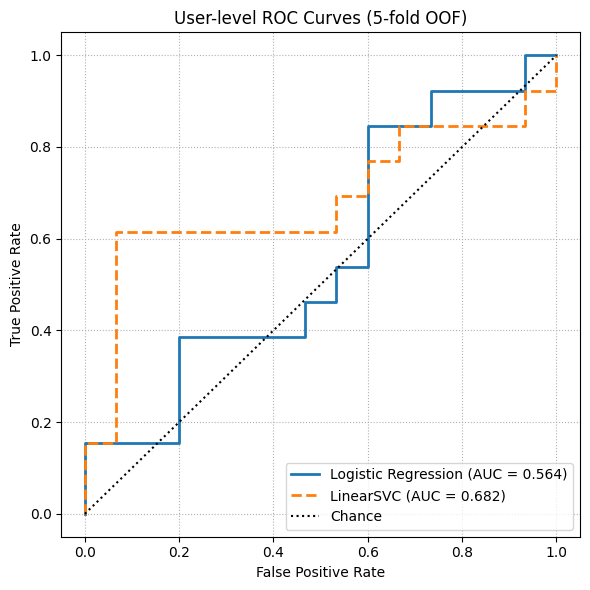

,model,roc_auc
0,Logistic Regression,0.564103
1,LinearSVC,0.682051


In [20]:
## ROC–AUC (user-level, out-of-fold)

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import pandas as pd

# Reuse the existing CV splitter if defined; otherwise define one
try:
    cv = skf  # from earlier cells
except NameError:
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Logistic Regression: use predicted probabilities (positive class = 1)
log_reg = LogisticRegression(max_iter=1000)
oof_proba_lr = cross_val_predict(log_reg, X, y, cv=cv, method='predict_proba')
oof_score_lr = oof_proba_lr[:, 1]  # probability of class 1
auc_lr = roc_auc_score(y, oof_score_lr)
fpr_lr, tpr_lr, _ = roc_curve(y, oof_score_lr)

# LinearSVC: use decision function scores
svm = LinearSVC(max_iter=10000)
oof_dec_svm = cross_val_predict(svm, X, y, cv=cv, method='decision_function')
auc_svm = roc_auc_score(y, oof_dec_svm)
fpr_svm, tpr_svm, _ = roc_curve(y, oof_dec_svm)

# Plot ROC curves
plt.figure(figsize=(6, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.3f})', linewidth=2)
plt.plot(fpr_svm, tpr_svm, label=f'LinearSVC (AUC = {auc_svm:.3f})', linestyle='--', linewidth=2)
plt.plot([0, 1], [0, 1], 'k:', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('User-level ROC Curves (5-fold OOF)')
plt.legend(loc='lower right')
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()

# Optional: display/save the AUC table
auc_df = pd.DataFrame({
    'model': ['Logistic Regression', 'LinearSVC'],
    'roc_auc': [auc_lr, auc_svm]
})
display(auc_df)
# auc_df.to_latex('roc_auc_user_level.tex', index=False)